In [112]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


## Data Preprocessing

In [113]:
# Hyperparameters

# y column normalize scaler
normalizer_constant = 2

# time series step size
time_step = 14

# NN parameters
learning_rate = 0.1
num_epoch = 500
NN_layer_dimension = [100,100]
train_size = 568 # 80% of the data

In [173]:
SNP = pd.read_csv('./SP500.csv')

# get all attributes
SNP_attributes = SNP.iloc[:,2:7]
# get last column (y)
SNP_price = SNP.iloc[:,-1:]

# normalize the data using MinMax scaller
scaler = MinMaxScaler()
scaler.fit(SNP_attributes)
SNP_attributes = scaler.transform(SNP_attributes)

Price_scaler = MinMaxScaler(feature_range=(0,1))
Price_scaler.fit(SNP_price)
SNP_price = Price_scaler.transform(SNP_price)

# scale data to [0,1]
# SNP_price = (SNP_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())

train_data = SNP_price[0:train_size, :]
train_data_mul = SNP_attributes[0:train_size, :]
# train_data_mul = np.array(train_data_mul)

# univariate
def create_train_data(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i,0])
        y.append(data[i,0])
    return x, y

# multivariate
def create_train_data_mul(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0:data.shape[1]])
        y.append(data[i:i+1,0])
    return x, y

X_train, y_train = create_train_data_mul(train_data_mul)


In [174]:
# Reshaping 
X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train

array([[0.00220812],
       [0.00271769],
       [0.00343958],
       [0.00355803],
       [0.00334347],
       [0.00328983],
       [0.00396702],
       [0.00386421],
       [0.00438049],
       [0.00398714],
       [0.00450341],
       [0.00498168],
       [0.0051873 ],
       [0.00549125],
       [0.00559853],
       [0.00580191],
       [0.00609692],
       [0.00640981],
       [0.00612821],
       [0.00665342],
       [0.00677634],
       [0.00670706],
       [0.00668024],
       [0.00740883],
       [0.00737978],
       [0.00709594],
       [0.00771502],
       [0.00760104],
       [0.00664001],
       [0.00676517],
       [0.00732167],
       [0.00794522],
       [0.00849501],
       [0.00831398],
       [0.00844584],
       [0.00859782],
       [0.00822682],
       [0.00778207],
       [0.00820671],
       [0.00708923],
       [0.00677858],
       [0.00652379],
       [0.00507108],
       [0.00489452],
       [0.00576391],
       [0.00581979],
       [0.00580191],
       [0.007

In [175]:
# NN 
def create_model(units=[12,3], learning_rate=0.3):
    model = tf.keras.models.Sequential()
    # # LSTM RNN model
    model.add(LSTM(units=64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=32,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    # opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer='adam',loss='mean_squared_error')

    return model

model = create_model(units=NN_layer_dimension, learning_rate=learning_rate)




In [176]:
# Train
model.fit(X_train, y_train, epochs=num_epoch, batch_size=25, verbose=1)

Epoch 1/500
23/23 [==============================] - 2s 10ms/step - loss: 0.0025
Epoch 2/500
23/23 [==============================] - 0s 8ms/step - loss: 5.3243e-04
Epoch 3/500
23/23 [==============================] - 0s 9ms/step - loss: 5.2018e-04
Epoch 4/500
23/23 [==============================] - 0s 8ms/step - loss: 4.3561e-04
Epoch 5/500
23/23 [==============================] - 0s 8ms/step - loss: 3.3234e-04
Epoch 6/500
23/23 [==============================] - 0s 8ms/step - loss: 3.5906e-04
Epoch 7/500
23/23 [==============================] - 0s 8ms/step - loss: 3.5102e-04
Epoch 8/500
23/23 [==============================] - 0s 8ms/step - loss: 3.6195e-04
Epoch 9/500
23/23 [==============================] - 0s 8ms/step - loss: 3.1235e-04
Epoch 10/500
23/23 [==============================] - 0s 8ms/step - loss: 2.4269e-04
Epoch 11/500
23/23 [==============================] - 0s 8ms/step - loss: 2.6630e-04
Epoch 12/500
23/23 [==============================] - 0s 8ms/step - loss: 2.5

In [178]:
# test data 
test_data = SNP_price[train_size - time_step:, :]
test_data_mul = SNP_attributes[train_size - time_step:, :]
# test_data_mul = np.array(test_data_mul)
X_test = []
X_test_mul = []
y_test = SNP_price[train_size:, :]
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i,0])


for i in range(time_step, len(test_data_mul)):
    X_test_mul.append(test_data_mul[i-time_step:i,0:test_data_mul.shape[1]])


X_test, X_test_mul = np.array(X_test), np.array(X_test_mul)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# X_test_mul = np.reshape(X_test_mul, (X_test_mul.shape[0], X_test_mul.shape[1], 1))


In [179]:
# predicted_price = model.predict(X_test)
predicted_price_mul = model.predict(X_test_mul)
# predicted_price = Price_scaler.inverse_transform(predicted_price)
predicted_price_mul = np.repeat(predicted_price_mul,X_test_mul.shape[2],axis=-1)
predicted_price_mul = scaler.inverse_transform(predicted_price_mul)[:,0]
predicted_price_mul

array([ 733.8009 ,  692.1615 ,  701.4643 ,  610.8941 ,  689.5525 ,
        741.3715 ,  848.0677 ,  933.9248 , 1000.02936,  951.2849 ,
        927.95386, 1046.2314 , 1152.751  , 1209.9238 , 1123.4032 ,
       1140.9077 , 1176.0024 , 1061.9844 , 1124.2567 , 1066.3262 ,
       1058.5352 , 1065.0176 , 1147.6322 , 1203.4288 , 1270.927  ,
       1380.4025 , 1380.1478 , 1408.377  , 1366.1652 , 1279.7726 ,
       1176.8617 , 1284.5894 , 1184.1727 , 1122.6797 , 1157.628  ,
       1235.8191 , 1265.9921 , 1305.7413 , 1233.031  , 1384.0741 ,
       1391.7229 , 1393.1786 , 1396.1854 , 1354.4357 , 1361.9491 ,
       1348.7246 , 1453.7128 , 1461.0156 , 1516.1864 , 1531.7407 ,
       1635.6008 , 1576.5353 , 1696.9409 , 1559.9896 , 1663.7831 ,
       1728.2737 , 1737.5068 , 1745.1777 , 1705.7781 , 1886.4563 ,
       1848.6759 , 1859.0726 , 1889.179  , 1908.0798 , 1829.8967 ,
       1922.4951 , 1809.838  , 1975.1775 , 1960.5769 , 1940.9069 ,
       1880.3585 , 2061.1096 , 1868.4779 , 1986.8102 , 1920.89

/var/folders/86/p93c5vrd78lblk3lsz04s3r00000gn/T/ipykernel_4605/161469088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_price_mul


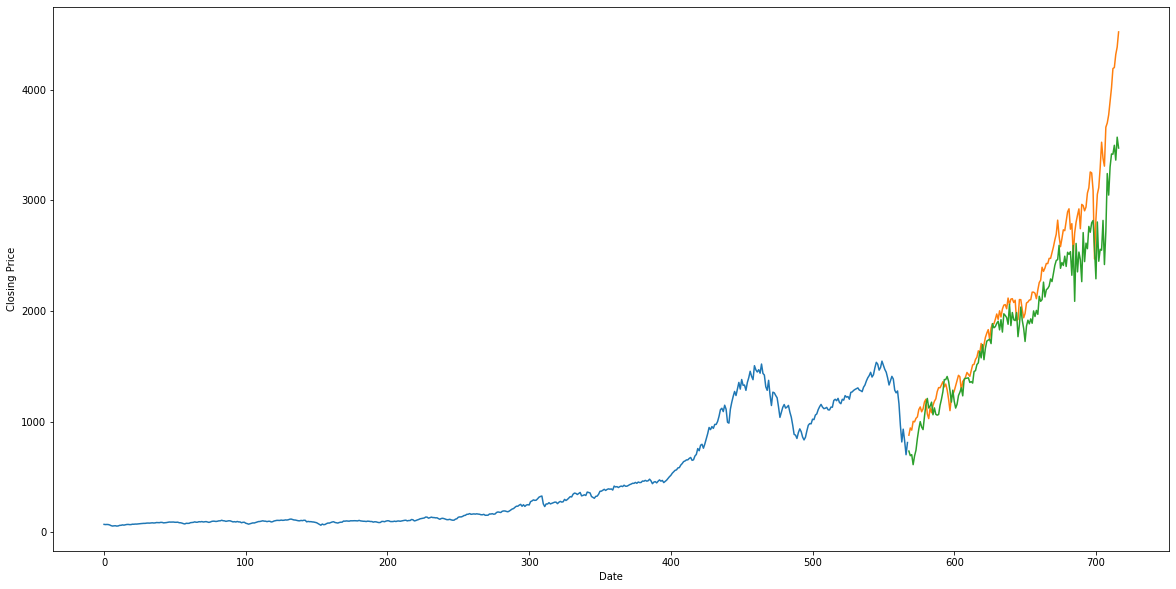

In [180]:
plt.figure(figsize=(20,10))
training = SNP[:train_size]
valid = SNP[train_size:]
valid['pred'] = predicted_price_mul


#plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(training["Closing Price"])
plt.plot(valid[['Closing Price', 'pred']])

